In [2]:
import os
import re
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt

In [3]:
from visturing.properties.prop8 import load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, prepare_and_correlate_order, calculate_spearman, calculate_pearson_stack

In [4]:
root_path = "../../Data/Experiment_8"

In [5]:
import scipy
exp8_low = scipy.io.loadmat('resp_legge_energy_3.mat')
exp8_high = scipy.io.loadmat('resp_legge_energy_12.mat')

xs = exp8_high["C"][0]
xs.shape

(20,)

In [6]:
data_high = {re.findall("high_(\w+)\.", p)[0]: np.load(p) for p in glob(os.path.join(root_path, "*")) if "high" in p}
for k, v in data_high.items(): print(k, v.shape)

achrom (5, 20, 256, 256, 3)
yellow_blue (5, 20, 256, 256, 3)
red_green (5, 20, 256, 256, 3)


In [7]:
data_low = {re.findall("low_(\w+)\.", p)[0]: np.load(p) for p in glob(os.path.join(root_path, "*")) if "_low_" in p}
for k, v in data_low.items(): print(k, v.shape)

red_green (5, 20, 256, 256, 3)
yellow_blue (5, 20, 256, 256, 3)
achrom (5, 20, 256, 256, 3)


In [8]:
c_mask = ['No mask', 'C_mask = 0.075', 'C_mask = 0.150', 'C_mask = 0.225', 'C_mask = 0.300']

In [9]:
# for name, chroma in data.items():
#     for dat in chroma:
#         fig, axes = plt.subplots(1,len(dat))
#         for ax, d in zip(axes.ravel(), dat):
#             ax.imshow(d)
#             ax.axis("off")
#         plt.show()

In [10]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import PerceptNet
from paramperceptnet.configs import param_config

In [11]:
model_name = "ppnet-fully-trained"

In [12]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [13]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
state = variables["state"]
params = variables["params"]

In [14]:
model = PerceptNet(config)

In [15]:
params.keys()

dict_keys(['CenterSurroundLogSigmaK_0', 'Color', 'GDNGamma_0', 'GDNGaussian_0', 'GDNSpatioChromaFreqOrient_0', 'GDN_0', 'GaborLayerGammaHumanLike__0', 'LinearScaling_0'])

In [16]:
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0]
    b = extra_b["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [17]:
def obtain_results(data):
    diffs = defaultdict(dict)
    for name, chroma in data.items():
        for f, dat in zip(c_mask, chroma):
            diffs_ = calculate_diffs(dat, dat[0:1])
            diffs[name][f] = diffs_
    return diffs

In [18]:
diffs_high = obtain_results(data_high)
diffs_low = obtain_results(data_low)

In [19]:
colors = [(0,0,1), (0,0,0), (0.3, 0.3, 0.3), (0.6, 0.6, 0.6), (1,0,0)]

In [20]:
def plot_diffs(diffs):
    fig, axes = plt.subplots(1,len(diffs), figsize=(12,4))
    for (name, chroma), ax in zip(diffs.items(), axes.ravel()):
        for (f, dat), color in zip(chroma.items(), colors):
            ax.plot(xs, dat, label=f, color=color)
            # ax.plot(dat)
        ax.legend()
        ax.set_title(name)
    plt.show()

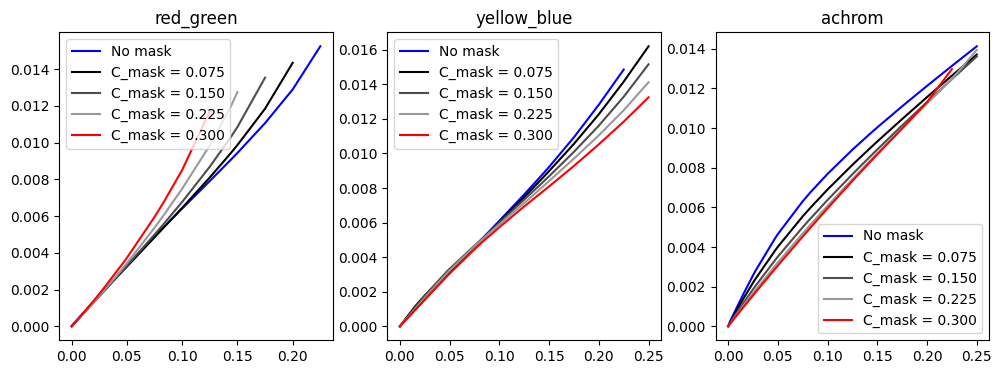

In [21]:
plot_diffs(diffs_low)

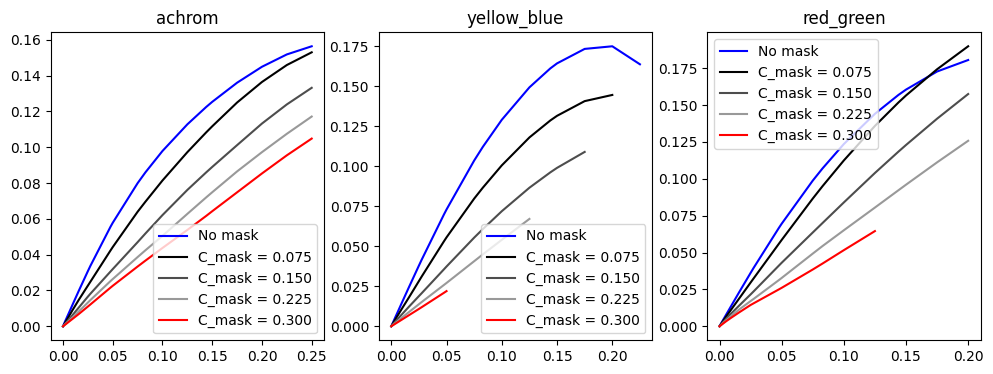

In [22]:
plot_diffs(diffs_high)

In [23]:
x_gt, y_low_gt, y_high_gt  = load_ground_truth("../../ground_truth_decalogo")
x_gt.shape, y_low_gt.shape, y_high_gt.shape

((55,), (55,), (55,))

In [24]:
diffs_low_a_s = np.array([a for a in diffs_low["achrom"].values()])
diffs_low_rg_s = np.array([a for a in diffs_low["red_green"].values()])
diffs_low_yb_s = np.array([a for a in diffs_low["yellow_blue"].values()])
diffs_low_a_s.shape, diffs_low_rg_s.shape, diffs_low_yb_s.shape

((5, 20), (5, 20), (5, 20))

In [25]:
bs = []
for b in diffs_low_a_s:
    a, b, c, d = prepare_data(xs, b, x_gt, y_low_gt)
    bs.append(b)
b_low = np.array(bs)
a.shape, b_low.shape, c.shape, d.shape

((55,), (5, 55), (55,), (55,))

In [26]:
calculate_spearman(b_low, ideal_ordering=[0,1,2,3,4])

{'spearman': np.float64(0.8854545454545455),
 'kendall': np.float64(0.8473388429752066),
 'pearson': np.float64(0.8854545454545453)}

In [27]:
diffs_high_a_s = np.array([a for a in diffs_high["achrom"].values()])
diffs_high_a_s.shape

(5, 20)

In [28]:
bs = []
for b in diffs_high_a_s:
    a, b, c, d = prepare_data(xs, b, x_gt, y_high_gt)
    bs.append(b)
b_high = np.array(bs)
a.shape, b_high.shape, c.shape, d.shape

((55,), (5, 55), (55,), (55,))

In [29]:
calculate_spearman(b_high, ideal_ordering=[0,1,2,3,4])

{'spearman': np.float64(0.9636363636363635),
 'kendall': np.float64(0.9636363636363635),
 'pearson': np.float64(0.9636363636363634)}

In [30]:
import scipy.stats as stats
stats.pearsonr(
    np.concatenate([
        b_low[0], b_high[0]
    ]),
    np.concatenate([
        y_low_gt, y_high_gt
    ])
)

PearsonRResult(statistic=np.float64(0.29252756112689027), pvalue=np.float64(0.0019277809399863889))